In [39]:
import glob
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
import shapely
import matplotlib.colors as colors
from IPython.display import clear_output
from tqdm.notebook import tqdm
import time
from IPython.core.display import display, HTML
import numpy as np
import matplotlib.pyplot as plt
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging
from pykrige.uk import UniversalKriging
display(HTML("<style>.container { width:100% !important; }</style>"))

/var/folders/xt/52zb2sgj4q9f84tyf9cg1yf00000gn/T/ipykernel_3172/1679906244.py:12: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# https://34c031f8-c9fd-4018-8c5a-4159cdff6b0d-cdn-endpoint.azureedge.net/-/media/calfire-website/what-we-do/fire-resource-assessment-program---frap/historic-fire-perimeters-data-dictionary_updatedjune2023.pdf?rev=cf22c8e76e9d4d3998f9b5f2bef01df0&hash=DBCCF699AAAECAF981C13FC51BD9B2A1
file_list = ['./fire22_1.gdb/a000000af.gdbtable',
             './fire22_1.gdb/a000000b8.gdbtable',
             './fire22_1.gdb/a000000b9.gdbtable',
             './fire22_1.gdb/a000000ba.gdbtable',]

In [3]:
fires = geopandas.GeoDataFrame()
for filename in tqdm(file_list):
    fires_temp = geopandas.read_file(filename)
    fires_temp = fires_temp.to_crs('epsg:4326')
    fires = geopandas.GeoDataFrame(pd.concat([fires, fires_temp], ignore_index=True))
    

month = []
year = []
alarm = fires["ALARM_DATE"].notnull()
cont = fires["CONT_DATE"].notnull()
start = fires["START_DATE"].notnull()
end = fires["END_DATE"].notnull()
for i in tqdm(range(len(fires))):
    date = ""
    if (alarm[i]):
        date = fires["ALARM_DATE"][i]
    elif (cont[i]):
        date = fires["CONT_DATE"][i]
    elif (start[i]):
        date = fires["START_DATE"][i]
    elif (end[i]):
        date = fires["END_DATE"][i]
    if (date == ""):
        month.append(np.nan)
        year.append(np.nan)
    else:
        date = str(date)
        month.append(int(date.split("-")[1]))
        year.append(int(date.split("-")[0]))
fires["MONTH"] = month
fires["YEAR"] = year
fires = fires[~fires.duplicated()]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/52506 [00:00<?, ?it/s]

In [26]:
fires_select = fires.loc[(fires["YEAR"] >= 2017) & (fires["YEAR"] <= 2022) & (fires["MONTH"] >= 7) & (fires["MONTH"] <= 8)]

In [27]:
import pandas as pd
import geopandas
cell_geo = pd.read_pickle("./dataframes/cell_geometry")
cell = geopandas.GeoDataFrame(cell_geo, columns=['geometry'], 
                                 crs='epsg:4326')

In [28]:
points = np.array((fires_select["geometry"].centroid.x, fires_select["geometry"].centroid.y)).T
values = np.array(fires_select['GIS_ACRES'])
xi = np.array((cell["geometry"].to_crs('epsg:4326').centroid.x, cell["geometry"].to_crs('epsg:4326').centroid.y)).T

/var/folders/xt/52zb2sgj4q9f84tyf9cg1yf00000gn/T/ipykernel_3172/2171924977.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  points = np.array((fires_select["geometry"].centroid.x, fires_select["geometry"].centroid.y)).T
/var/folders/xt/52zb2sgj4q9f84tyf9cg1yf00000gn/T/ipykernel_3172/2171924977.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  xi = np.array((cell["geometry"].to_crs('epsg:4326').centroid.x, cell["geometry"].to_crs('epsg:4326').centroid.y)).T


Text(0.5, 1.0, 'Acres Burned')

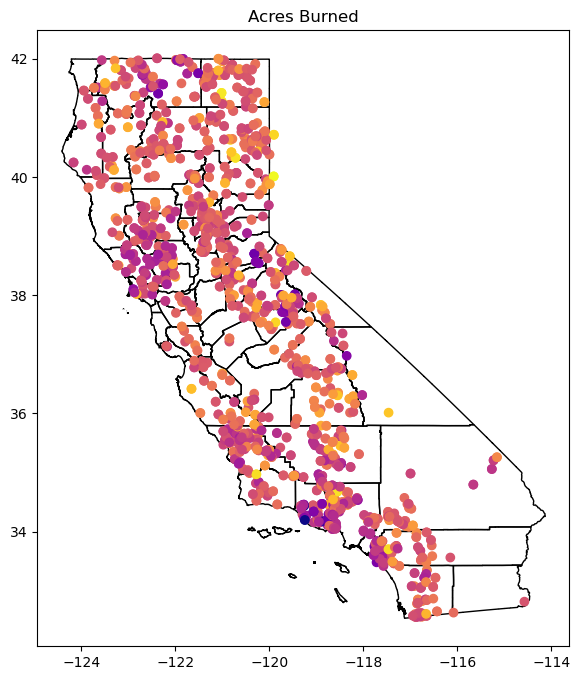

In [54]:
ax = world.to_crs(cell.crs).plot(color = "none", edgecolor = 'black', figsize = (12,8))
plt.scatter(points.T[0], points.T[1], c=np.log(values), cmap = "plasma")
plt.title('Acres Burned')

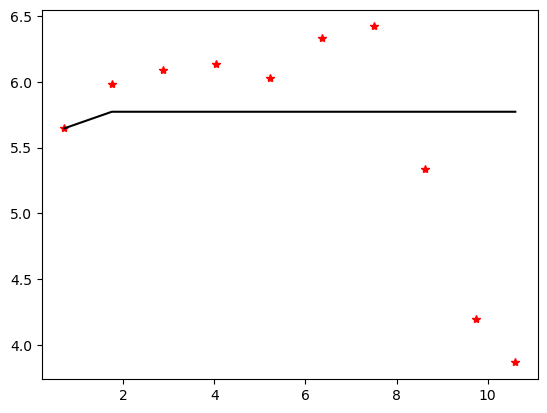

In [30]:
OK = OrdinaryKriging(
    points.T[0],
    points.T[1],
    np.log(values),
    variogram_model='gaussian',
    enable_plotting=True,
    coordinates_type="geographic",
    nlags=10,
)

In [31]:
len(xi)

200569

In [32]:
zstar, ss = OK.execute("points", xi.T[0], xi.T[1])

In [33]:
world = geopandas.read_file('/Users/christopher/Downloads/ark28722-s73w23-geojson.json')
import matplotlib.colors as colors

def plotter(dataset):
    cell["interpolated_value"] = dataset
    ax = cell.plot(column='interpolated_value', figsize=(12, 8), cmap='plasma', legend=True)
    world.to_crs(cell.crs).plot(ax = ax, color = "none", edgecolor = 'black', figsize = (12,8))

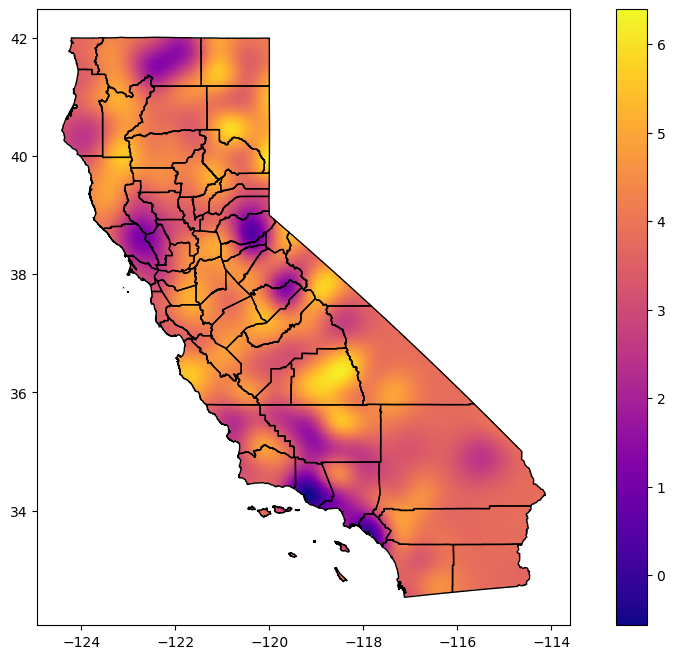

In [34]:
plotter(zstar)

In [36]:
cell["interpolated_value"] = zstar
cell["interpolated_value"].to_pickle("./dataframes/ordinaryKriging_gaussian_2017_2022_geographic_10lags_z")

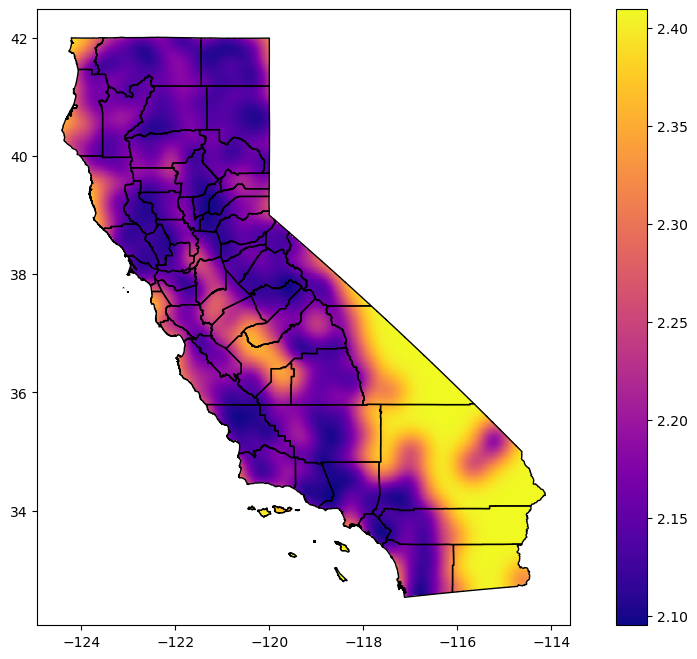

In [35]:
plotter(np.sqrt(ss))

In [37]:
cell["interpolated_value"] = np.sqrt(ss)
cell["interpolated_value"].to_pickle("./dataframes/ordinaryKriging_gaussian_2017_2022_geographic_10lags_std")

In [55]:
UK = UniversalKriging(
points.T[0],
points.T[1],
np.log(values),
variogram_model="gaussian",
)

In [56]:
zuniversal, ssuniversal = UK.execute("points", xi.T[0], xi.T[1])

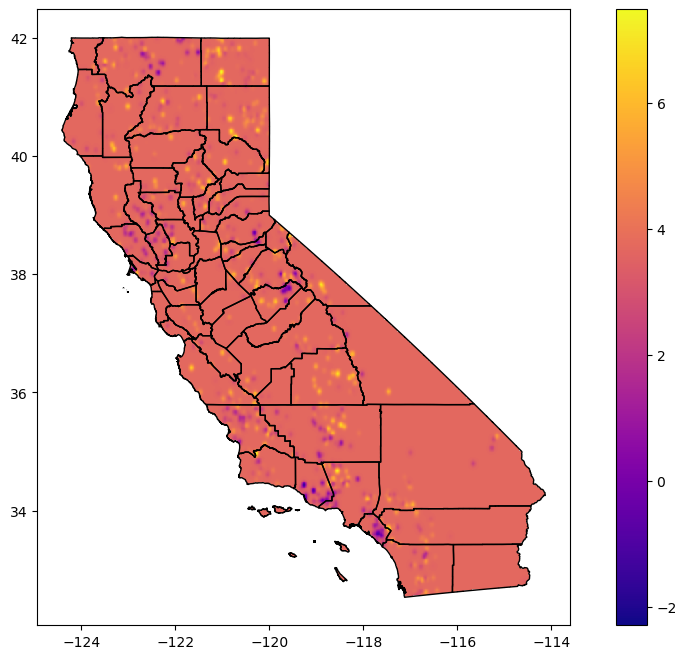

In [57]:
plotter(zuniversal)

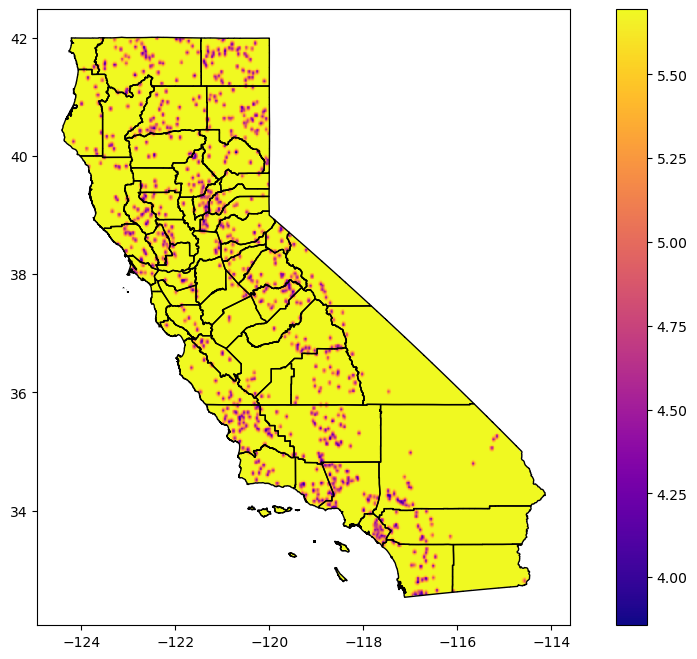

In [58]:
plotter(ssuniversal)